In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:37353")
client

<Client: 'tcp://127.0.0.1:37353' processes=8 threads=40, memory=157.35 GiB>

In [2]:
import numpy as np
import xarray as xr
import os.path as op
import xrft
import gsw
import pandas
from scipy.interpolate import PchipInterpolator, interp1d
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
from fastjmd95 import rho as densjmd95
from fastjmd95 import drhods, drhodt
# import MITgcmutils as mitutils
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import matplotlib.animation as animation  
%matplotlib inline
from scipy.sparse import coo_matrix, linalg

In [3]:
# Physical coefficients 
grav = 9.81
rho0 = 999.8
Cp = 3.994e3
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20

# Time set-up
years = np.arange(1967,1968,dtype=int)
dnf = 2160 #time interval
nfile = 73 #time steps in a year
ini_time = 1419120
fin_time = 1574640
ntimes = np.arange(ini_time,fin_time+dnf,dnf).reshape(len(years),nfile)
dates = pandas.date_range(start='1967-01-03',end='1967-12-29',periods=73)

# Ensemble members 
membs = np.arange(100,148,dtype=int)

# Domain selection 
ychunk = 450
xchunk = 250
ystart = -15
yend = 50


In [4]:
ddir = '/tank/chaocean/qjamet/RUNS/ORAR/reruns2/'
gdir = '/tank/chaocean/grid_chaO/gridMIT_update1/'
savedir_old = '/tank/topog/lsun/modewater/' # Saves cs_snap and maximum_cs
savedir = '/tank/spectre/lsun/modewater/' 
bdir = 'bcoor/'
twadir = 'TWA/'
figdir = '/tank/users/lsun/figures/modewater/' # Directory for figures

[20.         20.66039559 21.21804097 21.69635862 22.11217782 22.47790425
 22.80288576 23.09430175 23.3577593  23.59770297 23.81770297 24.02066171
 24.20896461 24.3845919  24.54920276 24.70419948 24.8507769  24.98996109
 25.12263974 25.24958647 25.37148027 25.48892134 25.60244398 25.71252733
 25.81960417 25.92406844 26.02628154 26.12657776 26.225269   26.32264884
 26.41899627 26.51457895 26.6096563  26.70448231 26.79930831 26.89438566
 26.98996834 27.08631577 27.18369561 27.28238685 27.38268307 27.48489617
 27.58936044 27.69643728 27.80652063 27.92004327 28.03748434 28.15937814
 28.28632487 28.41900352 28.55818771 28.70476513 28.85976185 29.02437271
 29.2       ] [19.62131183 20.3448473  20.9504106  21.46593983 21.91122042 22.30065892
 22.64499668 22.95240767 23.22922415 23.48042948 23.71000087 23.92115276
 24.11651298 24.29825232 24.46818136 24.62782385 24.77847291 24.92123474
 25.05706283 25.18678514 25.31112579 25.43072259 25.54614134 25.65788753
 25.76641611 25.87213959 25.97543491 

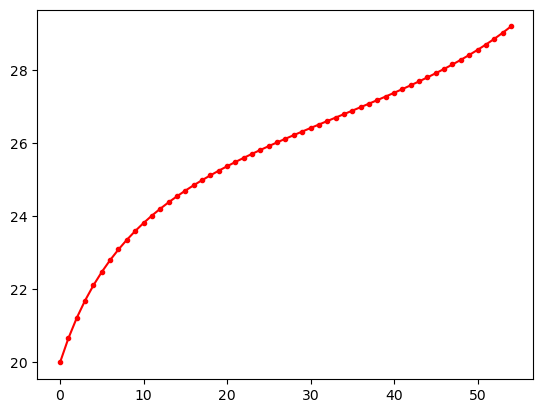

In [5]:
# Determine density layers?
Dsig = 9.2
sigmin = 20.
nlayers = 55
xs, xe = (-1.2,0.8)
tan1 = np.tan(np.arange(xs, xe, (xe-xs)/nlayers))
amp = (tan1.max()-tan1.min())
siglayers = (tan1-tan1.min())*amp**-1*Dsig + sigmin
tan2 = np.tan(np.arange(xs-(xe-xs)/(2*nlayers), xe, (xe-xs)/nlayers))
sigp1layers = (tan2-tan1.min())*amp**-1*Dsig + sigmin
print(siglayers,sigp1layers)
sigchunk = 10
nremap = 140
plt.plot(siglayers,'r.-')

In [ ]:
import warnings
warnings.filterwarnings("ignore")

dCs = 1e-5 # Correction added to the maximum sound speed Cs to avoid a singular point
Cs = xr.open_zarr(op.join(savedir_old,'Max_sound-speed_snap/run1967/')).Cs

yy = 0 
for year in years: 
    for itime in ntimes[yy,18:]:
        for imemb in membs:
            ds_tmp = open_mdsdataset(op.join(ddir,'memb%02d/run%4d/ocn/' % (imemb,year)), 
                                     grid_dir=gdir,
                                     prefix=['snap_diagOcn'], 
                                     delta_t=2e2, iters=itime,
                                     chunks={'XC':xchunk,'XG':xchunk,'YC':ychunk,'YG':ychunk}
                                    )
           

            ds = ds_tmp.sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                   YG=slice(ystart-12**-1,yend+2*12**-1))  
            
            ds_cs = xr.open_zarr(op.join(savedir_old,'cs_snap/run%4d/%010d/' 
                                   % (year,itime))).sel(nmemb=imemb-100) 
            cs = ds_cs.cs.where(ds.maskC!=0.).chunk({'Z':-1})
            
            theta = ds.THETA.where(ds.maskC!=0.)
            salt = ds.SALT.where(ds.maskC!=0.)
            
            pres = rho0*grav*(-ds.Z) * 1e-4
            presp1 = grav*(-ds.Zp1)*rho0 * 1e-4
            
            xA = ds.hFacW * ds.dyG * ds.drF
            yA = ds.hFacS * ds.dxG * ds.drF
            dxC_r = ds.dxC**-1
            dyC_r = ds.dyC**-1
            dxG_r = ds.dxG**-1
            dyG_r = ds.dyG**-1
            drF_r = ds.drF**-1
            drC_r = ds.drC**-1
            hFacC_r = ds.hFacC**-1
            rA_r = ds.rA**-1
            
            grid = Grid(ds, periodic=['X'])
            grid_sub = Grid(ds.sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                   YG=slice(ystart-12**-1,yend+2*12**-1)), 
                            periodic=['X']
                           )
            
############################################
#                   Rhos                   #
############################################
            rho_til = rho0*(1. - grav*(-grid.cumsum((Cs+dCs)**-2*ds.drF, 'Z',
                                                    boundary='extend', to='outer')
                                          )
                               ).chunk({'Zp1':-1})
           
            # rho at cell center    
            rho_outer = xr.apply_ufunc(densjmd95, 
                                       grid.interp(salt,'Z',boundary='extend',to='outer'
                                                  ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)), 
                                       grid.interp(theta,'Z',boundary='extend',to='outer'
                                                  ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)), 
                                       presp1, 
                                       dask='parallelized', output_dtypes=[float,]
                                      ).chunk({'XC':xchunk,'YC':ychunk})
            # rho at cell faces at u_location 
            rhox = xr.apply_ufunc(densjmd95, 
                                  grid.interp(grid.interp(salt,'X'
                                                         ).where(ds.maskW!=0.).sel(YC=slice(ystart-12**-1,
                                                                                            yend+2*12**-1)),
                                              'Z',boundary='extend',to='outer'), 
                                  grid.interp(grid.interp(theta,'X'
                                                         ).where(ds.maskW!=0.).sel(YC=slice(ystart-12**-1,
                                                                                            yend+2*12**-1)),
                                              'Z',boundary='extend',to='outer'), 
                                  presp1, 
                                  dask='parallelized', output_dtypes=[float,]
                                 ).chunk({'XG':xchunk,'YC':ychunk})
            # rho at at cell faces at v_location 
            rhoy = xr.apply_ufunc(densjmd95, 
                                  grid.interp(grid.interp(salt,'Y',boundary='extend'
                                                         ).where(ds.maskS!=0.).sel(YG=slice(ystart-12**-1,
                                                                                            yend+2*12**-1)),
                                              'Z',boundary='extend',to='outer'), 
                                  grid.interp(grid.interp(theta,'Y',boundary='extend'
                                                         ).where(ds.maskS!=0.).sel(YG=slice(ystart-12**-1,
                                                                                            yend+2*12**-1)),
                                              'Z',boundary='extend',to='outer'), 
                                  presp1,
                                  dask='parallelized', output_dtypes=[float,]
                                 ).chunk({'XC':xchunk,'YG':ychunk})

            delta_outer = (rho_outer - rho_til).chunk({'Zp1':-1}).rename('delta_outer')
            deltax_outer = (rhox - rho_til).chunk({'Zp1':-1}).rename('deltax_outer')
            deltay_outer = (rhoy - rho_til).chunk({'Zp1':-1}).rename('deltay_outer')
            

            # Velocity
            if imemb == membs[0]:
                u = grid_sub.transform((ds.UVEL).where(ds.maskW!=0.).fillna(0.).sel(YC=slice(ystart-12**-1,
                                                                                           yend+2*12**-1)
                                                                                 ).chunk({'YC':ychunk,
                                                                                          'XG':xchunk}),
                                         'Z',
                                         sigp1layers,
                                         method='conservative',
                                         target_data=deltax_outer)
                v = grid_sub.transform((ds.VVEL).where(ds.maskS!=0.).fillna(0.).sel(YG=slice(ystart-12**-1,
                                                                                           yend+2*12**-1)
                                                                                 ).chunk({'YG':ychunk,
                                                                                          'XC':xchunk}),
                                         'Z',
                                         sigp1layers,
                                         method='conservative',
                                         target_data=deltay_outer)
            else:
                u = xr.concat([u, grid_sub.transform((ds.UVEL).where(ds.maskW!=0.).fillna(0.).sel(YC=slice(ystart-12**-1,
                                                                                           yend+2*12**-1)
                                                                                 ).chunk({'YC':ychunk,
                                                                                          'XG':xchunk}),
                                         'Z',
                                         sigp1layers,
                                         method='conservative',
                                         target_data=deltax_outer)
                              ], 'imemb')
                v = xr.concat([v, grid_sub.transform((ds.VVEL).where(ds.maskS!=0.).fillna(0.).sel(YG=slice(ystart-12**-1,
                                                                                           yend+2*12**-1)
                                                                                 ).chunk({'YG':ychunk,
                                                                                          'XC':xchunk}),
                                         'Z',
                                         sigp1layers,
                                         method='conservative',
                                         target_data=deltay_outer)
                              ], 'imemb')
        
        dsb = xr.open_zarr(op.join(savedir,twadir,'run%4d/Dynb/%010d/' 
                               % (year,itime))
                      ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                            YG=slice(ystart-12**-1,yend+2*12**-1)
                           ).reset_coords(drop=True)
        uhat = dsb.uhat
        vhat = dsb.vhat
        
        ubar = (u.mean('imemb')).rename({'deltax_outer': 'delta_outer'}).isel(time = 0)
        vbar = (v.mean('imemb')).rename({'deltay_outer': 'delta_outer'}).isel(time = 0)

        u_bolus = uhat - ubar
        v_bolus = vhat - vbar
        
        dsave = ubar.to_dataset(name='ubar')
        dsave['vbar'] = vbar
        dsave['ubolus'] = u_bolus
        dsave['vbolus'] = v_bolus
        dsave.to_zarr(op.join(savedir,twadir,'run%4d/bolus/%010d/' 
                                            % (year,itime)), mode='w')
        # if itime == ntimes[0,0]:
        #     ubar = u.mean('imemb')
        #     vbar = v.mean('imemb')
        
        #     # uhat = dsb.uhat
        #     # vhat = dsb.vhat
        # else: 
        #     ubar = xr.concat([ubar, u.mean('imemb')], 'time')
        #     vbar = xr.concat([vbar, v.mean('imemb')], 'time')
        
        #     uhat = xr.concat([uhat, dsb.uhat], 'time')
        #     vhat = xr.concat([vhat, dsb.vhat], 'time')
        print(itime)
    
        

1458000
1460160
1462320
1464480


In [29]:
dsave

<xarray.Dataset>
Dimensions:      (YC: 783, XG: 1000, delta_outer: 55, XC: 1000, YG: 783)
Coordinates: (12/15)
    iter         int64 dask.array<chunksize=(), meta=np.ndarray>
    time         timedelta64[ns] 3285 days
  * YC           (YC) float32 -15.08 -15.0 -14.92 -14.83 ... 49.92 50.0 50.08
  * XG           (XG) float32 262.0 262.0 262.1 262.2 ... 347.8 347.8 347.9
    dyG          (YC, XG) >f4 dask.array<chunksize=(450, 250), meta=np.ndarray>
    dxC          (YC, XG) >f4 dask.array<chunksize=(450, 250), meta=np.ndarray>
    ...           ...
  * XC           (XC) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * YG           (YG) float32 -15.04 -14.96 -14.87 -14.79 ... 49.96 50.04 50.13
    dxG          (YG, XC) >f4 dask.array<chunksize=(450, 250), meta=np.ndarray>
    dyC          (YG, XC) >f4 dask.array<chunksize=(450, 250), meta=np.ndarray>
    rAs          (YG, XC) >f4 dask.array<chunksize=(450, 250), meta=np.ndarray>
    maskInS      (YG, XC) bool dask.array<chunksize=(450, 250), meta=np.ndarray>
Data variables:
    ubar         (YC, XG, delta_outer) float32 dask.array<chunksize=(450, 250, 55), meta=np.ndarray>
    vbar         (YG, XC, delta_outer) float32 dask.array<chunksize=(450, 250, 55), meta=np.ndarray>
    ubolus       (YC, XG, delta_outer) float32 dask.array<chunksize=(450, 250, 55), meta=np.ndarray>
    vbolus       (YG, XC, delta_outer) float32 dask.array<chunksize=(450, 250, 55), meta=np.ndarray>

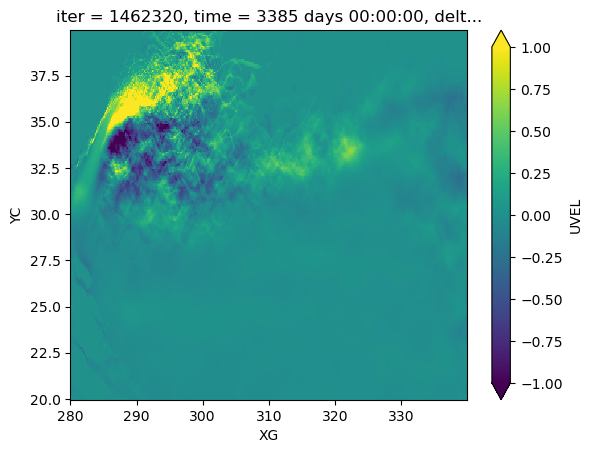

In [9]:
ubar.isel(time = 20, deltax_outer = 21).sel(XG = slice(280, 340), YC = slice(20,40)).plot(vmin = -1, vmax = 1)

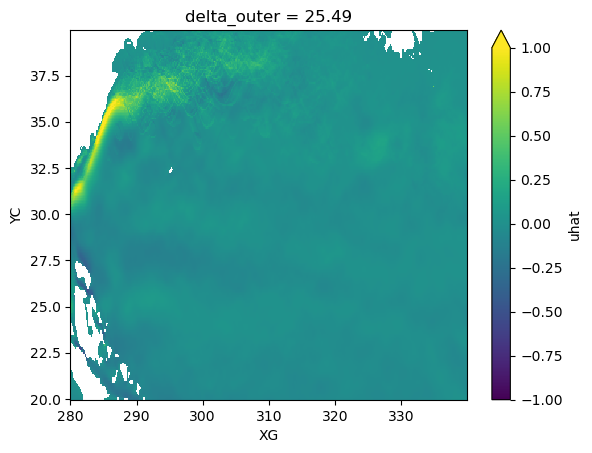

In [15]:
uhat.isel(time = 20, delta_outer = 21).sel(XG = slice(280, 340), YC = slice(20,40)).plot(vmin = -1, vmax = 1)

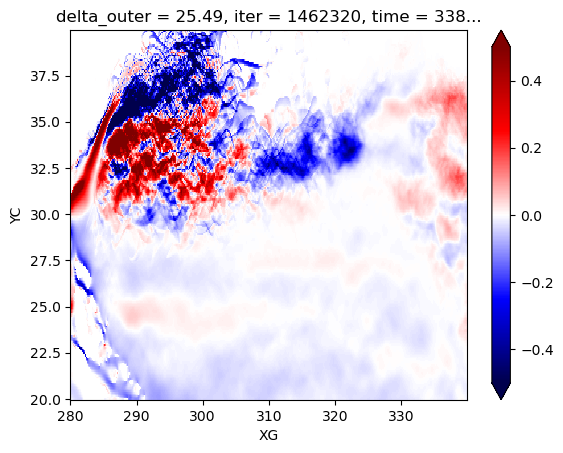

In [12]:
(uhat.isel(delta_outer = 21,time = 20)-ubar.isel(time = 20, deltax_outer = 21)
).sel(XG = slice(280, 340), YC = slice(20,40)).plot(cmap = 'seismic', vmax = 0.5)

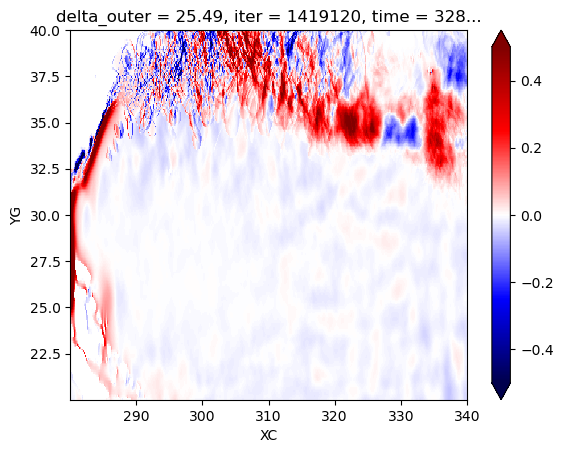

In [20]:
(vhat.isel(delta_outer = 21)-vbar.isel(time = 0, deltay_outer = 21)
).sel(XC = slice(280, 340), YG = slice(20,40)).plot(cmap = 'seismic', vmax = 0.5)